Getting Data

In [324]:
"""
Computes correlations for the cleaned data.
"""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from data_cleaning import get_cleaned_data


# from data_labels import get_desc_table

df = get_cleaned_data()

C:\Users\xabbo\AppData\Local\Temp/ipykernel_17208/2621732590.py:14: DtypeWarning: Columns (30,157,383,384,393,480,724,725,762) have mixed types.Specify dtype option on import or set low_memory=False.
  df = get_cleaned_data()


In [325]:
# eliminating diagonal values
corr_values = df.corr()
np.fill_diagonal(corr_values.values, 0)

Pre Processing

In [326]:
# Sanity check to enforce correlations are within [-1.0, 1.0]
for column in corr_values:
    corr_values[column].mask(corr_values[column] >= 1.0, np.nan, inplace=True)
    corr_values[column].mask(corr_values[column] <= -1.0, np.nan, inplace=True)

# for each row, ensure that a correlation exists > |.5|
# if not, record the row
rows_delete = []
for index, row in corr_values.iterrows():
    delete = True
    for value in row: 
        if (value >= 0.5 or value <= -0.5):
            delete = False
    # record a list of (row index, Delete?) listings
    rows_delete.append(tuple([index, delete]))

In [327]:
# masking all correlations < |.5| to be nan
def mask_(elem):
    if elem < 0.5 and elem > -0.5 and type(elem) != str:
        return np.nan
    else:
        return elem

corr_values = corr_values.applymap(mask_)

corr_values

,STUDYID,PATID,VISIT,MISC_TARC_PAT_VISIT,CCR,CCR_YES,CCR_CL_IMPRESS_CODE,CCR_MCIAMEM,CCR_MCIAPLUS,CCR_MCIAPLAN,...,P1_BGRESULT,P1_BIOSERUM,P1_BUFFY,P1_CSF,P1_HRSAFTFOOT,P1_PLASMA,P1_SERUM,P1_SHARE_AGREE,P1_WHOLEBLOOD,P1_WHYNOTALL
STUDYID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PATID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VISIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MISC_TARC_PAT_VISIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P1_PLASMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.994251,NaN,NaN,NaN,0.900279,NaN,0.767234,-0.513783
P1_SERUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.898397,NaN,NaN,0.900279,NaN,NaN,0.803079,-0.514754
P1_SHARE_AGREE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1_WHOLEBLOOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.766687,NaN,NaN,0.767234,0.803079,NaN,NaN,-0.639301


In [328]:
# Now, delete row/columns that we've identified as not containing meaningful correlations
# Initial size = 735x735, reduced is 644x644

for row in rows_delete:
    if row[1]:
        corr_values = corr_values.iloc[corr_values.index!=row[0], corr_values.columns!=row[0]]

corr_values.shape

(644, 644)

Top Correlations:

In [329]:
# following two functions identify top correlation pairs

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# isolating top 50 pairs to optimize feature visibility
top = get_top_abs_correlations(corr_values, 25)

In [330]:
# recording all rows + columns of interest
topdf = top.unstack(level=-1)

# recording all rows/cols into a set
features = set(list(topdf.columns) + topdf.axes[0].tolist())
len(features)

34

In [331]:
# filtering out nonimportant features

for col in corr_values.columns:
    if col not in features or col == "PATID":
        corr_values = corr_values.iloc[corr_values.index != col, corr_values.columns != col]

corr_values.shape
corr_values

,A41_PMBS,A43_ADDRT,A44_SSASTMO,A44_SSBSTMO,A44_SSBSTYR,A44_SSCSTMO,A44_SSCSTYR,A44_SSDRT,A5_TIA4YR,C1_WAISR_DIGIB,...,RBM_CEA,RBM_EGF,RBM_Active_GLP_1,RBM_Haptoglobin,RBM_MMP_3,Q1_YKL_40,F1_PSMS2,F1_PSMS4,F1_PSMS6,I1_INSEX
A41_PMBS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN
A43_ADDRT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A44_SSASTMO,NaN,NaN,NaN,0.909952,NaN,NaN,-0.997949,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
A44_SSBSTMO,NaN,NaN,0.909952,NaN,NaN,0.617888,-0.532948,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.593091
A44_SSBSTYR,NaN,NaN,NaN,NaN,NaN,NaN,0.962140,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
A44_SSCSTMO,NaN,NaN,NaN,0.617888,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.825120,-0.825120,NaN,-0.609872
A44_SSCSTYR,NaN,NaN,-0.997949,-0.532948,0.96214,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.707107
A44_SSDRT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A5_TIA4YR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1_WAISR_DIGIB,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,...,-1.0,-1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN


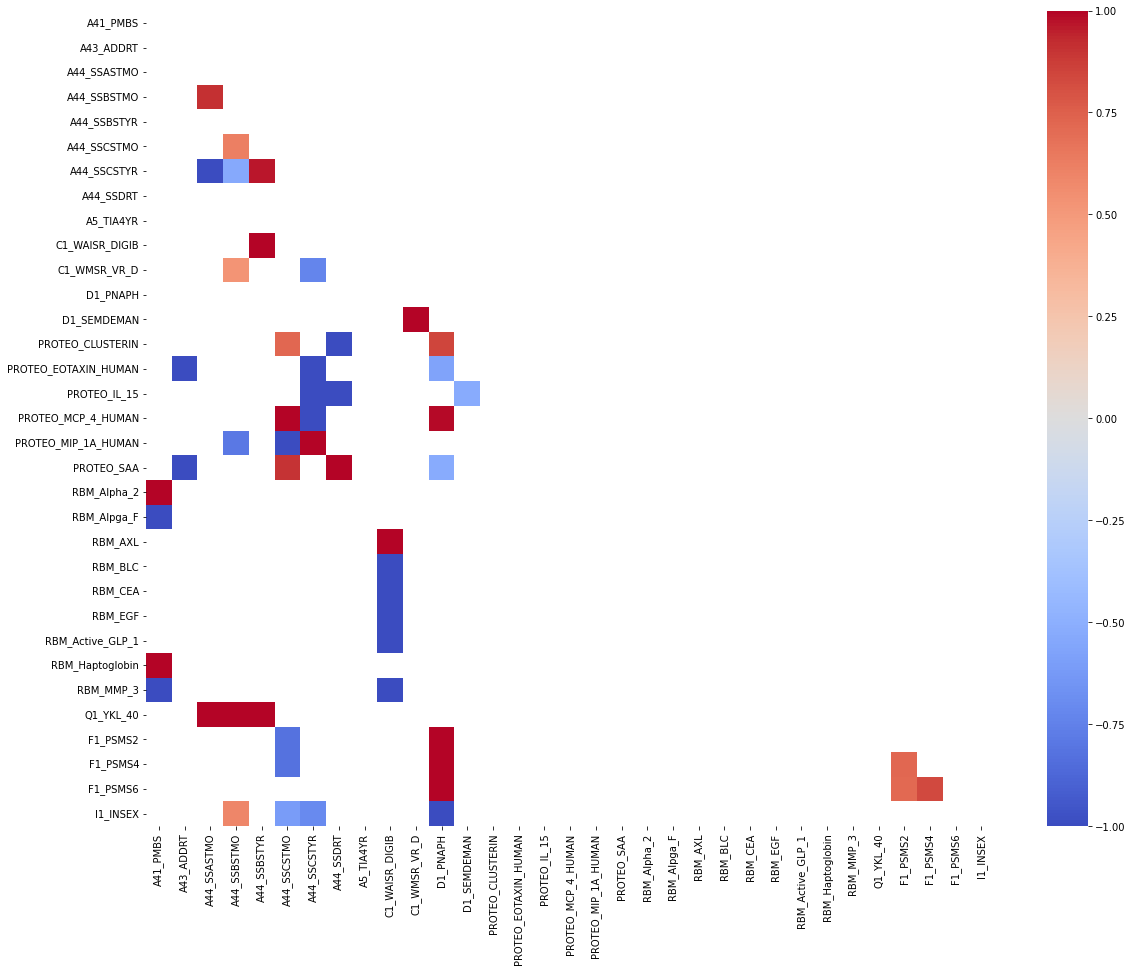

In [332]:
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_values, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_values[mask] = np.nan

plt.figure(figsize=(19,15))
sns.heatmap(corr_values, cmap="coolwarm")
plt.show()
#f = plt.figure(figsize=(19, 15))
#plt.matshow(corr_values, fignum=f.number)
#plt.xticks(range(corr_values.select_dtypes(['number']).shape[1]), corr_values.select_dtypes(['number']).columns, fontsize=14, rotation=90)
#plt.yticks(range(corr_values.select_dtypes(['number']).shape[1]), corr_values.select_dtypes(['number']).columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16)

In [333]:
codebook = pd.read_excel("20220602-TARCC-Codebook.xlsx")

codebook["Variable Name"] = codebook["Variable Name"].astype(str)

codebook["Variable Name"] = codebook["Variable Name"].apply(str.upper)

val = codebook[codebook["Variable Name"] == str('A41_PMBS')]["Description"].values


In [334]:
def get_desc_table(cols):
    descs = []
    for col in cols:
        entry = {}
        col = str(col).upper()
        row = codebook[codebook["Variable Name"] == col]
        entry["Variable Name"] = col
        entry["Description"] = row["Description"].values
        descs.append(entry)
    for entry in descs:
        if len(entry["Description"]) != 0:
            entry["Description"] = entry["Description"][0]
        else:
            entry["Description"] = "Incompatible"
    return descs

dictionary = get_desc_table(list(corr_values.columns))

In [335]:
print(len(dictionary), dictionary)

33 [{'Variable Name': 'A41_PMBS', 'Description': 'Prescription B: Strength'}, {'Variable Name': 'A43_ADDRT', 'Description': 'Anti-dementia Drug Hx D: Route'}, {'Variable Name': 'A44_SSASTMO', 'Description': 'Systemic Steroids Hx A: Start date (month)'}, {'Variable Name': 'A44_SSBSTMO', 'Description': 'Systemic Steroids Hx B: Start date (month)'}, {'Variable Name': 'A44_SSBSTYR', 'Description': 'Systemic Steroids Hx B: Start date (year)'}, {'Variable Name': 'A44_SSCSTMO', 'Description': 'Systemic Steroids Hx C: Start date (month)'}, {'Variable Name': 'A44_SSCSTYR', 'Description': 'Systemic Steroids Hx C: Start date (year)'}, {'Variable Name': 'A44_SSDRT', 'Description': 'Systemic Steroids Hx D: Route'}, {'Variable Name': 'A5_TIA4YR', 'Description': 'Year TIA occurred'}, {'Variable Name': 'C1_WAISR_DIGIB', 'Description': 'WAIS-R Digit Span Backward'}, {'Variable Name': 'C1_WMSR_VR_D', 'Description': 'WMS-R VR 1 Figure D'}, {'Variable Name': 'D1_PNAPH', 'Description': 'DX Progressive nonf

In [336]:
data_names = pd.DataFrame(data=dictionary)
data_names.to_excel("data_names.xlsx", index=False)